## Problem 4

Submitted by: 

Name: Pushya Shree Konasale Jayaramu

Matriculation no: 03776652

## 4.1 Relationship between every two variables

In [1]:
import pandas as pd
df = pd.read_csv(r'C:\Users\User15\OneDrive\Desktop\Data Analysis\data_problem_4.csv')
df.head()

,flow,occupancy,speed,speed_down,flow_ratio
0,21,2.7,66.1,65.909191,0.677419
1,15,2.4,66.2,66.598417,0.576923
2,14,2.3,66.1,64.354384,0.560000
3,17,2.5,66.2,64.640938,0.607143
4,15,2.3,66.2,66.139489,0.576923


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [4]:
#df.isnull()
df.describe()

,flow,occupancy,speed,speed_down,flow_ratio
count,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000
mean,33.636564,3.613767,64.153249,64.192374,0.729635
std,20.109043,1.325885,2.180747,2.556263,0.186815
min,7.000000,1.900000,58.000000,55.802034,0.368421
25%,14.000000,2.300000,62.400000,62.362837,0.560000
50%,33.000000,3.500000,64.900000,64.569426,0.797436
75%,49.000000,4.700000,66.100000,66.131141,0.890909
max,91.000000,7.400000,67.800000,70.370701,1.000000


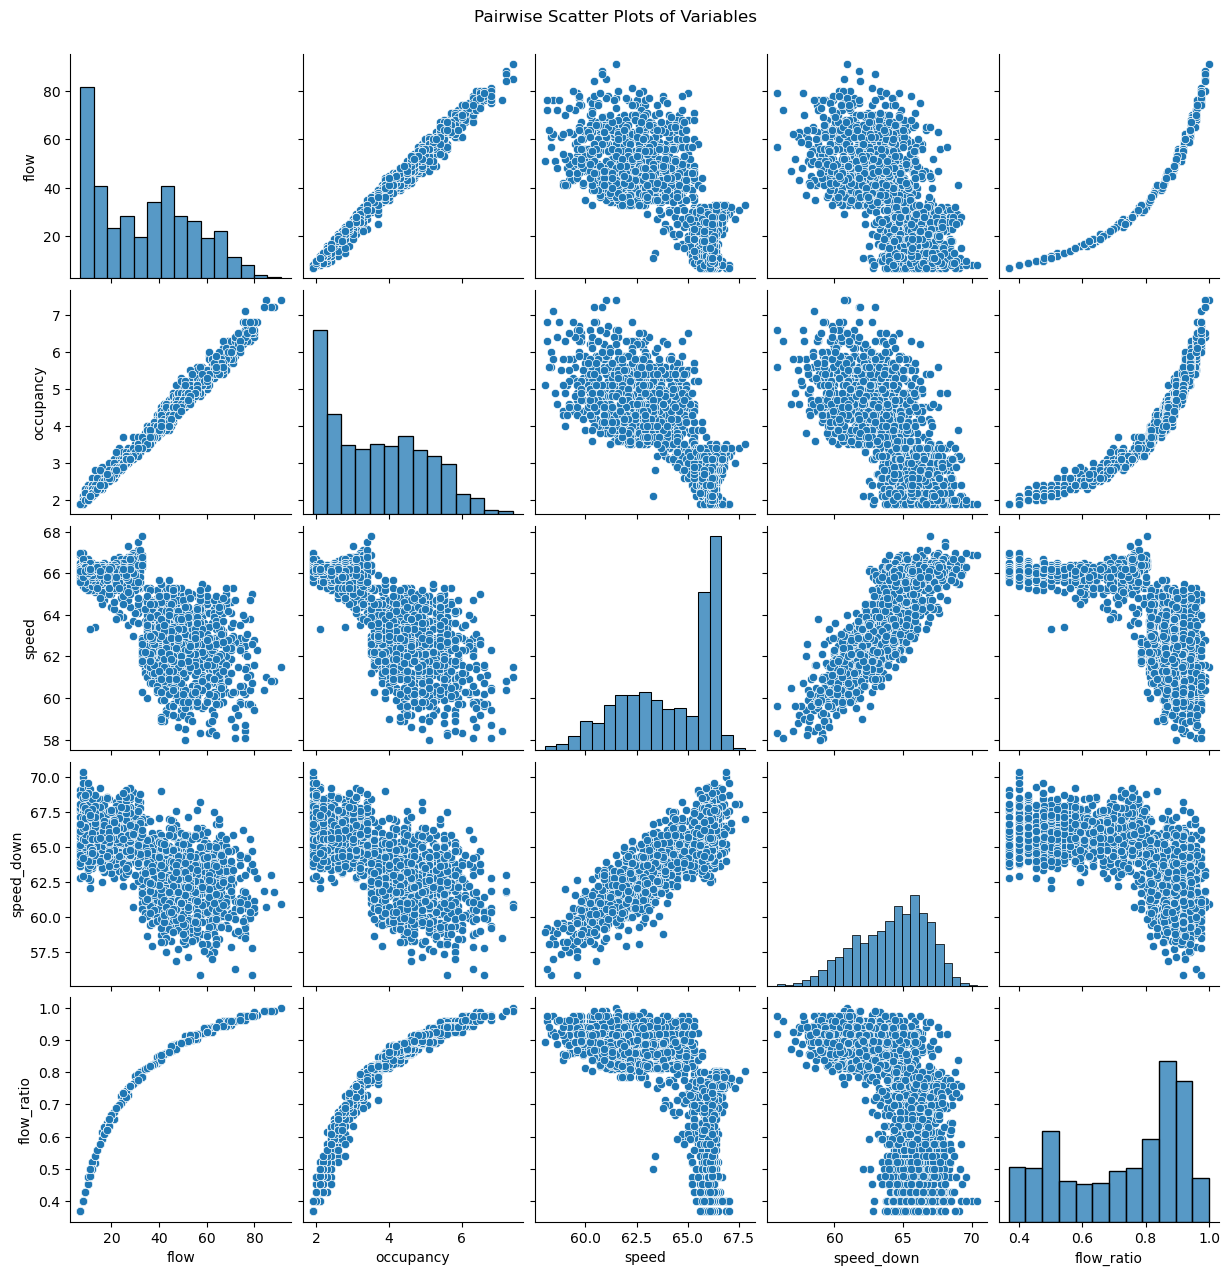

In [7]:
selected_variables = ['flow', 'occupancy', 'speed', 'speed_down', 'flow_ratio']

sns.pairplot(df[selected_variables])
plt.suptitle('Pairwise Scatter Plots of Variables', y=1.02)
plt.show()

### Interpretation:
1. High Positive Correlation between Flow and Occupancy
2. Non-linear Relationship between Flow Ratio and Flow/Occupancy
3. Negative Correlation between Speed/speed_down and Occupancy

## 4.2 Multiple linear regression model to the original dataset

In [14]:
selected_variables = ['flow', 'occupancy', 'speed_down', 'flow_ratio']
X = df[selected_variables]
y = df['speed']

# spliting into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=11)
print('Training observations are %d' % len(X_train))
print('Testing observations are %d' % len(X_test))

#Model
#standardisation of the data set
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)

reg = linear_model.LinearRegression()
reg.fit(X_train_scaler, y_train);

print('Independent variables: ', X_train.columns)
print('The estimated coefficients: ', reg.coef_)
print('The estimated intercept: ', reg.intercept_)

print('R^2 for training: %.2f' % reg.score(X_train_scaler, y_train))
print('R^2 for test: %.2f' % reg.score(X_test_scaler, y_test))

Training observations are 1452
Testing observations are 364
Independent variables:  Index(['flow', 'occupancy', 'speed_down', 'flow_ratio'], dtype='object')
The estimated coefficients:  [ 2.51784534 -3.10201334  1.2209478  -0.34000884]
The estimated intercept:  64.09559228650137
R^2 for training: 0.84
R^2 for test: 0.80


In [15]:
#trying statsmodel for details
X_train_scaled = sm.add_constant(X_train_scaler)
X_test_scaled = sm.add_constant(X_test_scaler)

model_train = sm.OLS(y_train, X_train_scaled).fit()
print(model_train.summary())

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1968.
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:31:47   Log-Likelihood:                -1849.8
No. Observations:                1452   AIC:                             3710.
Df Residuals:                    1447   BIC:                             3736.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.0956      0.023   2818.546      0.0

### Interpretation:

Multicollinerity Analysis:

From VIF and correlation marix analysis. Yes, there exist multicollinearity problem.

1. Flow and occupancy have very high correlation (0.99) and both have extremely high VIF values (104.237266 and 94.881279, respectively).
2. Flow and flow_ratio have high correlation (0.94) and flow has a very high VIF value (104.237266).
3. Occupancy and flow_ratio have high correlation (0.93) and occupancy has a very high VIF value (94.881279).

## 4.3 Suitable independent variables for the regression model

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = df[['flow', 'occupancy', 'speed_down', 'flow_ratio']]
X_with_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Print VIF data
print(vif_data)

      feature          VIF
0       const  1961.687481
1        flow   104.237266
2   occupancy    94.881279
3  speed_down     2.096501
4  flow_ratio     9.116577


In [32]:
# Manually calculate VIF for each feature to confirm high values
X = df[['flow', 'occupancy', 'speed_down', 'flow_ratio']]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

def calculate_vif(X):
    vif = []
    for i in range(X.shape[1]):
        X_i = X[:, i]
        X_not_i = np.delete(X, i, axis=1)
        model = sm.OLS(X_i, X_not_i).fit()
        r_squared_i = model.rsquared
        vif_i = 1 / (1 - r_squared_i)
        vif.append(vif_i)
    return vif

vif_data["VIF"] = calculate_vif(X.values)
print(vif_data)

      feature          VIF
0       const  1961.687481
1        flow   104.237266
2   occupancy    94.881279
3  speed_down     2.096501
4  flow_ratio     9.116577


                flow  occupancy  speed_down  flow_ratio
flow        1.000000   0.993891   -0.673001    0.942135
occupancy   0.993891   1.000000   -0.696856    0.932341
speed_down -0.673001  -0.696856    1.000000   -0.650333
flow_ratio  0.942135   0.932341   -0.650333    1.000000


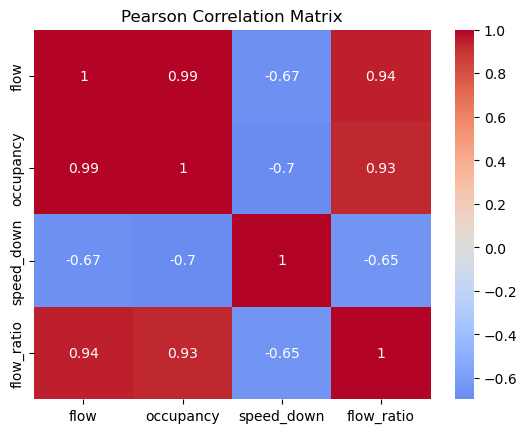

In [19]:
#Also pearson co-efficient confirmation
correlation_matrix = df[['flow', 'occupancy', 'speed_down', 'flow_ratio']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Matrix')
plt.show()

Since variables are highly correlated to each other:
1. Among highly correlated pairs of variables, single variable is retained to elimate the multicollinerity
2. Hence, Flow variable is elimated as it is highly correlated with occuancy and flow_ratio
3. Log and square transformations are applied on the remaining variables

Transformation Consideration:

Based on observations from Scatter Plots and Histograms above:

1. occupancy: 
- Shows a right-skewed distribution.
- Scatter plot suggests a non-linear relationship with speed.

2. speed_down:
- Shows a moderate negative correlation with occupancy and flow_ratio.
- Histogram suggests a somewhat right-skewed distribution.

3. flow_ratio:
- Shows a non-linear relationship with other variables.
- Histogram suggests a non-linear pattern and a right-skewed distribution.

Transformations Considered:

1. occupancy: Log transformation
- Reason: Log transformation can reduce skewness and stabilize variance, which is useful for right-skewed data.

2. speed_down: Square transformation
- Reason: Squaring can linearize relationships and help in cases where the original variable is not linear.

3. flow_ratio: Square root transformation
- Reason: The square root transformation can address non-linear patterns and stabilize variance.

Source: https://www.studysmarter.co.uk/explanations/engineering/engineering-mathematics/transform-variables-in-regression/

In [38]:
# Apply transformations
df['log_occupancy'] = np.log(df['occupancy'] + 1)  # Add 1 to avoid log(0)
df['speed_down_squared'] = df['speed_down'] ** 2
df['sqrt_flow_ratio'] = np.sqrt(df['flow_ratio'])
df['flow_sqr'] = df['flow']**2

In [43]:
X_transformed = df[['log_occupancy', 'speed_down_squared', 'sqrt_flow_ratio']]
X_transformed = sm.add_constant(X_transformed)

vif_data_transformed = pd.DataFrame()
vif_data_transformed["feature"] = X_transformed.columns

def calculate_vif(X):
    vif = []
    for i in range(X.shape[1]):
        X_i = X[:, i]
        X_not_i = np.delete(X, i, axis=1)
        model = sm.OLS(X_i, X_not_i).fit()
        r_squared_i = model.rsquared
        vif_i = 1 / (1 - r_squared_i)
        vif.append(vif_i)
    return vif

vif_data_transformed["VIF"] = calculate_vif(X_transformed.values)
print(vif_data_transformed)

              feature         VIF
0               const  575.899416
1       log_occupancy   13.284312
2  speed_down_squared    2.013727
3     sqrt_flow_ratio   11.383054


                    log_occupancy  speed_down_squared  sqrt_flow_ratio
log_occupancy            1.000000           -0.701945         0.954076
speed_down_squared      -0.701945            1.000000        -0.638749
sqrt_flow_ratio          0.954076           -0.638749         1.000000


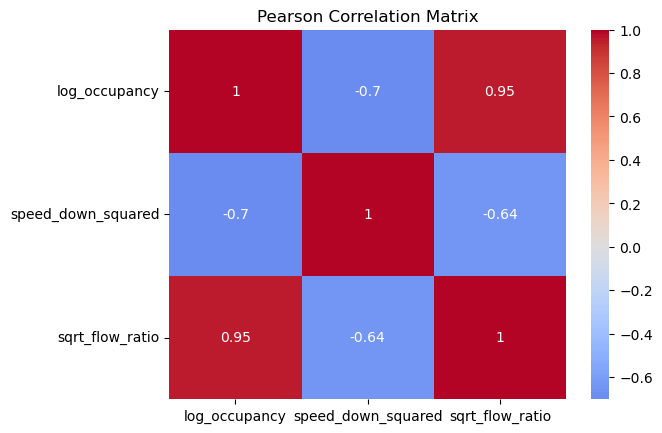

In [34]:
#Also pearson co-efficient confirmation
correlation_matrix = df[['log_occupancy', 'speed_down_squared', 'sqrt_flow_ratio']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Matrix')
plt.show()

There has been a significant reduction in VIF values after the transformation for occupancy, but still there is high correlation between occupancy and flow ratio. so, occupancy has been dropped from the model. 

Also, since sqrt_flow_ratio have more VIF than flow_ratio, Flow_ratio is retained for the model.

## 4.4 Final linear, ridge and lasso regression

In [56]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Linear regression
X = df[['speed_down_squared', 'flow_ratio']]
y = df['speed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_linear = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()
print(model_linear.summary())

linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

y_train_pred = linear_reg.predict(X_train_scaled)
y_test_pred = linear_reg.predict(X_test_scaled)

r2_train_linear = linear_reg.score(X_train_scaled, y_train)
r2_test_linear = linear_reg.score(X_test_scaled, y_test)

print("Linear Regression Coefficients:", linear_reg.coef_)
print("Linear Regression Intercept:", linear_reg.intercept_)
print("R^2 score for training set:", r2_train_linear)
print("R^2 score for testing set:", r2_test_linear)


                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     3061.
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:04:54   Log-Likelihood:                -1993.1
No. Observations:                1452   AIC:                             3992.
Df Residuals:                    1449   BIC:                             4008.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.1410      0.025   2557.208      0.0

### Interpretation:
1. Even though r^2 of the initial model is higher, f-statitics in the second model suggests astronger overall fit. 
2. Predicted co-efficients are more robust in second model due to reduced multicolleranity
3. Even though AIC and BIC values are higher in second model, it effectively adresses multicollinearity. 

In [63]:
#Original data set
X = df[['flow', 'occupancy', 'speed_down', 'flow_ratio']]
y = df['speed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit ridge regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# Calculate R^2 score for training and testing sets
r2_train_ridge = ridge.score(X_train_scaled, y_train)
r2_test_ridge = ridge.score(X_test_scaled, y_test)

print("Ridge Regression Coefficients:", ridge.coef_)
print("Ridge Regression Intercept:", ridge.intercept_)
print("R^2 score for training set:", r2_train_ridge)
print("R^2 score for testing set:", r2_test_ridge)


Ridge Regression Coefficients: [ 1.94504389 -2.58048574  1.2110389  -0.28960629]
Ridge Regression Intercept: 64.14097796143251
R^2 score for training set: 0.8396982994444901
R^2 score for testing set: 0.8456324047527827


In [68]:
#Lasso regression
# Fit lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

# Calculate R^2 score for training and testing sets
r2_train_lasso = lasso.score(X_train_scaled, y_train)
r2_test_lasso = lasso.score(X_test_scaled, y_test)

print("Lasso Regression Coefficients:", lasso.coef_)
print("Lasso Regression Intercept:", lasso.intercept_)
print("R^2 score for training set:", r2_train_lasso)
print("R^2 score for testing set:", r2_test_lasso)

Lasso Regression Coefficients: [-0.         -0.80897534  1.22478098 -0.        ]
Lasso Regression Intercept: 64.14097796143251
R^2 score for training set: 0.8273470311053106
R^2 score for testing set: 0.8324379844794977


### Comparision Interpretation:
1. Lasso: Elimination of flow and flow_ratio confirms that variables are less significant
2. Ridge: flow_ratio have small co-efficient proving that it has less impact on the model
3. Linear: Although linear final model eliminates flow variable, flow_ratio was still considered based on the VIF value.

Overall, the final selected variables except for flow_ratio was verified as significant predictors based on comparision with ridge and rasso interpretations.